In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

import datetime


In [191]:
# Load the data from both csv files into pandas dataframes

#Explore-logs-A-data-2024-04-05 17_17_53.csv
#Explore-logs-A-data-2024-04-05 18_03_00.csv

df1 = pd.read_csv('Explore-logs-A-data-2024-04-05 17_17_53.csv', header=None, skiprows=1)
df2 = pd.read_csv('Explore-logs-A-data-2024-04-05 18_03_00.csv', header=None, skiprows=1)
concatenated_df = pd.concat([df1, df2], ignore_index=True)



header = ["Time", "Line", "tsNs", "id", "Tempo", "app", "component", "container", "filename", "job", "namespace", "node_name", "pod", "prodeng", "stream"]
concatenated_df.columns = header


## Cleansing the information

In [ ]:
# Convert the "Time" column to datetime
# Time strings are in milliseconds since epoch

concatenated_df["datetime"] = pd.to_datetime(concatenated_df["Time"].astype(np.int64), unit="ms", origin="unix")

# concatenated_df.head(10)

In [193]:

bucket_size = '1H'

# Group the data by the determined bucket size and count the occurrences
data_counts = concatenated_df.groupby(pd.Grouper(key='datetime', freq=bucket_size)).size()

## Visualising the volume information

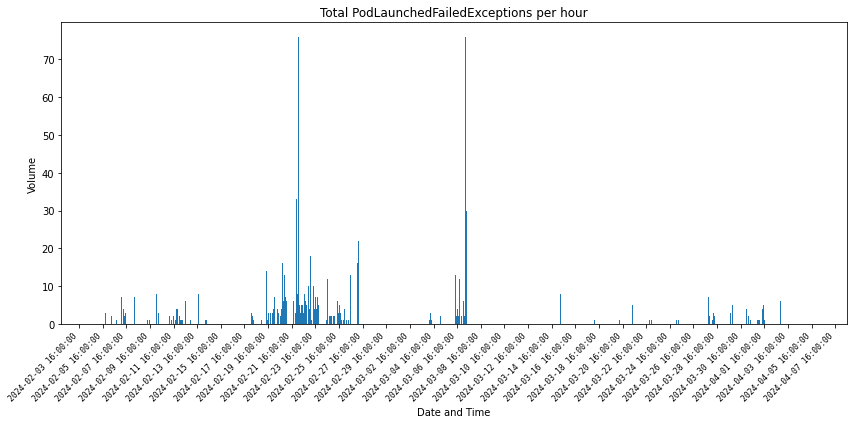

In [194]:
# Plot the time series histogram
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = (data_counts.index[1] - data_counts.index[0]) * 0.8  # Adjust the bar width as needed
ax.bar(data_counts.index, data_counts.values, width=bar_width)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45, ha='right', fontsize=8, fontweight='light', fontname='monospace')
# set more frequent x axis ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48))
ax.set_xlabel('Date and Time')
ax.set_ylabel('Volume')
ax.set_title('Total PodLaunchedFailedExceptions per hour')
plt.tight_layout()
plt.show()


# Getting total failures per pod.

In [195]:

# Strip the 8-character suffix from the pod names
concatenated_df["pod_name"] = concatenated_df["pod"].str[:-9]

# Group by pod_name and count failures
pod_failures = concatenated_df.groupby("pod_name").size().reset_index()
pod_failures.columns = ["pod_name", "failures"]

# Sort pod_failures by failure count in descending order
pod_failures = pod_failures.sort_values("failures", ascending=False)

# Write the failing pods to a CSV file, ordered by failure count
pod_failures.to_csv("pod_failures_total.csv", index=False)


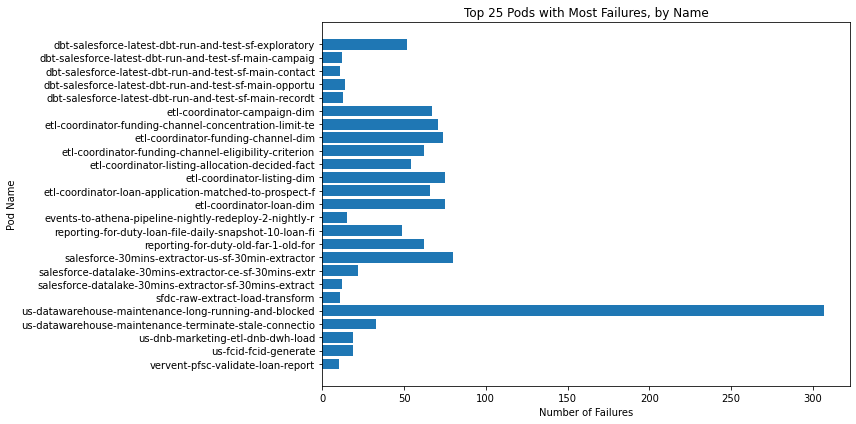

In [201]:
#sort top_pods by name
top_pods = top_pods.sort_values("pod_name", ascending=True)

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_pods["pod_name"], top_pods["failures"])

# Adjust the x-axis limits
ax.invert_yaxis()
ax.set_xlabel("Number of Failures")
ax.set_ylabel("Pod Name")
ax.set_title("Top 25 Pods with Most Failures, by Name")


# Adjust the layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()

In [204]:
# We need to check the pods that had 3 or more failures within a 15m window. We can use that as a decent check that the airflow task failed. Not perfect, but good enough for now.

# Group the data by pod_name and time window
pod_failures_window = concatenated_df.groupby(["pod_name", pd.Grouper(key='datetime', freq="15min")]).size().reset_index()
pod_failures_window.columns = ["pod_name", "datetime", "failures"]

pod_failures.head()


,pod_name,failures
173,us-datawarehouse-maintenance-long-running-and-...,307
166,salesforce-30mins-extractor-us-sf-30min-extractor,80
132,etl-coordinator-loan-dim,75
129,etl-coordinator-listing-dim,75
123,etl-coordinator-funding-channel-dim,74


In [205]:

# Filter the data to include only pods with 3 or more failures within a 1h window
pod_failures_window = pod_failures_window[pod_failures_window["failures"] >= 3]

# Sort the data by pod_name and datetime
pod_failures_window = pod_failures_window.sort_values(["pod_name", "datetime"])

# Write the data to a CSV file
pod_failures_window.to_csv("pod_failures_window_15m.csv", index=False)


In [ ]:

# OK, I now have a dataframe looking like this. Any row in this dataframe constitutes a "potential failure event".
# I would like to sum these potential failure events (every row being 1), per pod, per day, on a multi-series timeseries graph

In [206]:
pod_failures_window["fail_event"] = 1
pod_failures_window.head()



,pod_name,datetime,failures,fail_event
13,com-layer2-catalogue-dbt-run-and-test-l2a-mrkt...,2024-03-22 10:15:00,3,1
15,com-layer2-catalogue-dbt-run-and-test-l2a-mrkt...,2024-03-22 10:15:00,3,1
30,data-platform-utils-athena-query-metrics-us-at...,2024-02-27 07:00:00,4,1
31,datahub-ingest-business-glossary-common-busine...,2024-03-07 11:00:00,4,1
32,datahub-ingest-business-glossary-common-busine...,2024-03-07 11:15:00,4,1


In [207]:

# Convert datetime to DatetimeIndex and resample to daily frequency
pod_failures_window = pod_failures_window.set_index("datetime").groupby(["pod_name", pd.Grouper(freq="D")])["fail_event"].sum().reset_index()

# Unstack the data to have a column for each pod
# unstacked = pod_failures_window.set_index(["datetime", "pod_name"]).groupby([pd.Grouper(level="datetime", freq="D"), "pod_name"])["fail_event"].sum().reset_index()

pivot_data = pod_failures_window.pivot(index="datetime", columns="pod_name", values="fail_event")


pivot_data.head()


pod_name,com-layer2-catalogue-dbt-run-and-test-l2a-mrkt-exp-ltd,com-layer2-catalogue-dbt-run-and-test-l2a-mrkt-ml-full,data-platform-utils-athena-query-metrics-us-athena-que,datahub-ingest-business-glossary-common-business-gloss,dbt-salesforce-latest-dbt-run-and-test-sf-exploratory,dbt-salesforce-latest-dbt-run-and-test-sf-main-campaig,dbt-salesforce-latest-dbt-run-and-test-sf-main-case-mo,dbt-salesforce-latest-dbt-run-and-test-sf-main-contact,dbt-salesforce-latest-dbt-run-and-test-sf-main-line-of,dbt-salesforce-latest-dbt-run-and-test-sf-main-opportu,...,events-to-athena-pipeline-nightly-redeploy-2-nightly-r,loan-book-uk-dbt-run-and-test-trust-4-lb-model-fc-dbt,reporting-for-duty-loan-file-daily-snapshot-10-loan-fi,reporting-for-duty-old-far-1-old-for,salesforce-30mins-extractor-us-sf-30min-extractor,salesforce-datalake-30mins-extractor-ce-sf-30mins-extr,salesforce-datalake-30mins-extractor-sf-30mins-extract,us-datawarehouse-maintenance-long-running-and-blocked,us-dnb-marketing-etl-dnb-dwh-load,us-dnb-marketing-etl-dnb-validator
datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2024-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2024-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
2024-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2024-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


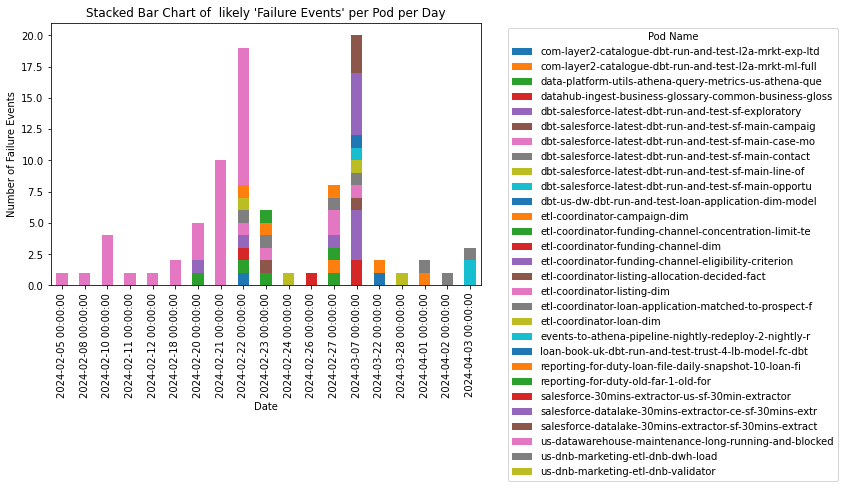

In [209]:

# Plot the pivoted data as a stacked bar chart
pivot_data.plot(kind="bar", stacked=True, figsize=(12, 6), xlabel="Date", ylabel="Number of Failure Events")
plt.legend(title="Pod Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Stacked Bar Chart of  likely 'Failure Events' per Pod per Day")
plt.tight_layout()
plt.show()